Mean Error: -0.4771
RMSE: 0.5512


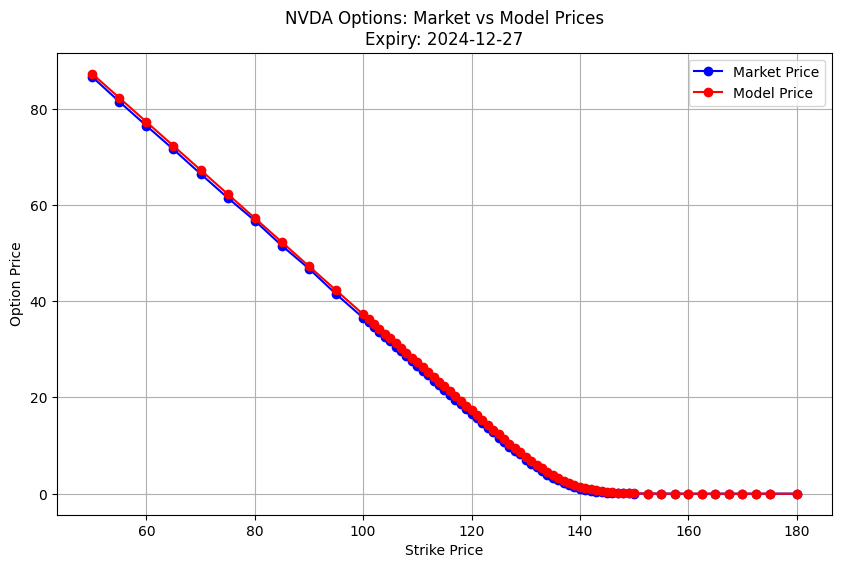

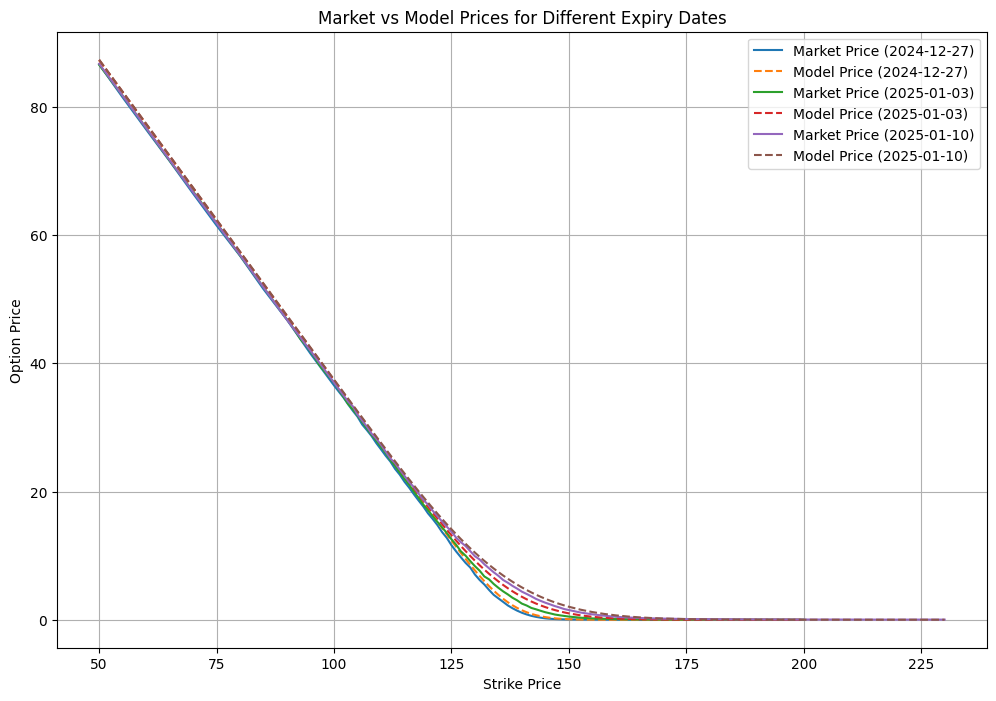

In [22]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
from scipy.special import comb
import matplotlib.pyplot as plt

def calculate_historical_volatility(symbol, period='1y'):
    """計算歷史波動率"""
    hist = yf.Ticker(symbol).history(period=period)
    daily_returns = np.log(hist['Close'] / hist['Close'].shift(1))
    return np.std(daily_returns) * np.sqrt(252)

def get_risk_free_rate():
    """獲取無風險利率（使用美國10年期國債收益率）"""
    try:
        treasury = yf.Ticker("^TNX")
        return treasury.info['regularMarketPrice'] / 100
    except:
        return 0.045  # 如果無法獲取，使用預設值

def binom_EU1_vectorized(S0, K, T, r, sigma, N, type_):
    """向量化二項式期權定價"""
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)

    i = np.arange(N + 1)
    node_prob = comb(N, i) * p**i * (1-p)**(N-i)
    ST = S0 * (u**i) * (d**(N-i))

    if type_ == 'call':
        payoff = np.maximum(ST - K, 0)
    elif type_ == 'put':
        payoff = np.maximum(K - ST, 0)
    else:
        raise ValueError("type_ must be 'call' or 'put'")

    return np.sum(payoff * node_prob) * np.exp(-r * T)

def get_data(symbol):
    """獲取市場數據並計算必要參數"""
    # 獲取波動率和無風險利率
    sigma = calculate_historical_volatility(symbol)
    r = get_risk_free_rate()

    # 獲取期權數據
    ticker = yf.Ticker(symbol)
    options = ticker.options
    current_price = ticker.history(period='1d')['Close'].iloc[-1]

    data = []
    for expiry in options[:3]:  # 處理前三個到期日
        try:
            calls = ticker.option_chain(expiry).calls
            calls['Expiry'] = expiry
            data.append(calls)
        except:
            continue

    if not data:
        raise ValueError("No option data available")

    df = pd.concat(data)
    df['mid_price'] = (df['ask'] + df['bid']) / 2
    df['Time'] = (pd.to_datetime(df['Expiry']) - pd.Timestamp.now()).dt.days / 365

    # 過濾有效數據
    df = df[(df['bid'] > 0) & (df['ask'] > 0)]

    return df, current_price, sigma, r

def plot_comparison(symbol, N=1000):
    """繪製市場價格與模型價格比較圖"""
    try:
        # 獲取數據和參數
        df, S0, sigma, r = get_data(symbol)

        # 計算模型價格
        df['Model_Price'] = df.apply(
            lambda row: binom_EU1_vectorized(
                S0, row['strike'], row['Time'],
                r, sigma, N, 'call'
            ), axis=1
        )

        # 計算誤差
        df['Error'] = df['mid_price'] - df['Model_Price']

        # 選擇特定到期日
        exp_date = df['Expiry'].unique()[0]
        exp1 = df[df['Expiry'] == exp_date]

        plt.figure(figsize=(10, 6))
        plt.plot(exp1['strike'], exp1['mid_price'], 'bo-', label='Market Price')
        plt.plot(exp1['strike'], exp1['Model_Price'], 'ro-', label='Model Price')
        plt.title(f"{symbol} Options: Market vs Model Prices\nExpiry: {exp_date}")
        plt.xlabel("Strike Price")
        plt.ylabel("Option Price")
        plt.legend()
        plt.grid(True)

        # 誤差分析
        mean_error = df['Error'].mean()
        rmse = np.sqrt((df['Error']**2).mean())
        print(f"Mean Error: {mean_error:.4f}")
        print(f"RMSE: {rmse:.4f}")
        plt.show()

        # 多到期日分析
        plt.figure(figsize=(12, 8))
        for expiry in df['Expiry'].unique():  # 依次處理每個到期日
            exp_df = df[df['Expiry'] == expiry]  # 過濾出該到期日的數據
            plt.plot(exp_df['strike'], exp_df['mid_price'], label=f'Market Price ({expiry})')
            plt.plot(exp_df['strike'], exp_df['Model_Price'], linestyle='--', label=f'Model Price ({expiry})')

        plt.title("Market vs Model Prices for Different Expiry Dates")
        plt.xlabel("Strike Price")
        plt.ylabel("Option Price")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    plot_comparison('NVDA')

<ipython-input-15-a77a8179aebe>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = ticker.history(period='1d')['Close'][-1]  # 即時股價


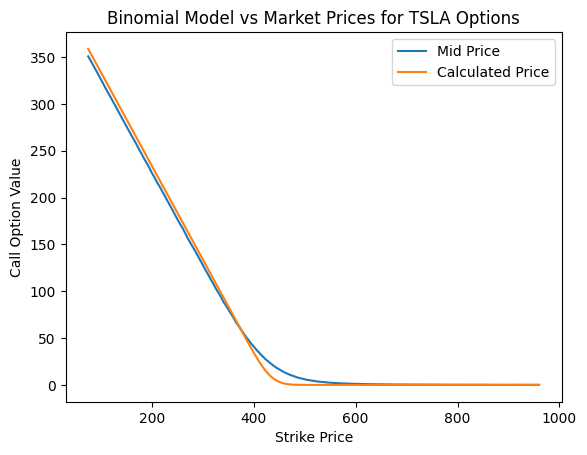

In [15]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt

def binom_EU1_vectorized(S0, K, T, r, sigma, N, type_):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)

    i = np.arange(N + 1)
    node_prob = comb(N, i) * p**i * (1-p)**(N-i)
    ST = S0 * (u**i) * (d**(N-i))

    if type_ == 'call':
        payoff = np.maximum(ST - K, 0)
    elif type_ == 'put':
        payoff = np.maximum(K - ST, 0)
    else:
        raise ValueError("type_ must be 'call' or 'put'")

    return np.sum(payoff * node_prob) * np.exp(-r * T)

def get_data(symbol):
    ticker = yf.Ticker(symbol)
    S0 = ticker.history(period='1d')['Close'][-1]  # 即時股價
    options = ticker.options  # 獲取期權到期日
    data = []
    for expiry in options[:3]:  # 只處理前三個到期日
        df = ticker.option_chain(expiry).calls
        df['Expiry'] = expiry
        df['Underlying_Price'] = S0
        data.append(df)
    df = pd.concat(data)
    df['mid_price'] = (df['ask'] + df['bid']) / 2
    df['Time'] = (pd.to_datetime(df['Expiry']) - pd.Timestamp.now()).dt.days / 255
    return df[(df['bid'] > 0) & (df['ask'] > 0)]

# 加載數據
df = get_data('TSLA')

# 設置合理的波動率與步數
sigma = 0.2  # 年化波動率（20%）
N = 100  # 時間步數

# 計算價格
df['Price'] = df.apply(lambda row: binom_EU1_vectorized(
    row['Underlying_Price'], row['strike'], row['Time'], 0.01, sigma, N, 'call'), axis=1
)
df['error'] = df['mid_price'] - df['Price']

# 選擇到期日
exp1 = df[(df['Expiry'] == df['Expiry'].unique()[2]) & (df['contractSymbol'].str.contains('C'))]

# 繪圖
plt.plot(exp1['strike'], exp1['mid_price'], label='Mid Price')
plt.plot(exp1['strike'], exp1['Price'], label='Calculated Price')
plt.title("Binomial Model vs Market Prices for TSLA Options")
plt.xlabel("Strike Price")
plt.ylabel("Call Option Value")
plt.legend()
plt.show()
